In [3]:
import glob, os
import pydicom
import matplotlib.pyplot as plt
import numpy as np

## Import images

In [9]:
file_names = []
for file in os.listdir("./alignment_images"):
    if file.endswith(".dcm"):
        file_name = os.path.join("./alignment_images/", file[:])
        print(file_name)
        file_names.append(file_name)

./alignment_images/IM-0002-0001.dcm
./alignment_images/IM-0002-0002.dcm
./alignment_images/IM-0002-0003.dcm
./alignment_images/IM-0002-0004.dcm
./alignment_images/IM-0002-0005.dcm
./alignment_images/IM-0002-0006.dcm
./alignment_images/IM-0002-0007.dcm
./alignment_images/IM-0002-0008.dcm
./alignment_images/IM-0002-0009.dcm
./alignment_images/IM-0002-0010.dcm
./alignment_images/IM-0002-0011.dcm
./alignment_images/IM-0002-0012.dcm
./alignment_images/IM-0002-0013.dcm
./alignment_images/IM-0002-0014.dcm
./alignment_images/IM-0002-0015.dcm
./alignment_images/IM-0002-0016.dcm
./alignment_images/IM-0002-0017.dcm
./alignment_images/IM-0002-0018.dcm
./alignment_images/IM-0002-0019.dcm
./alignment_images/IM-0002-0020.dcm
./alignment_images/IM-0002-0021.dcm
./alignment_images/IM-0002-0022.dcm
./alignment_images/IM-0002-0023.dcm
./alignment_images/IM-0002-0024.dcm
./alignment_images/IM-0002-0025.dcm
./alignment_images/IM-0002-0026.dcm
./alignment_images/IM-0002-0027.dcm
./alignment_images/IM-0002-0

Filename.........: ./alignment_images/IM-0002-0142.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.2
Patient's name...: ROBOT POSITION MARKER, 
Patient id.......: 0000200
Modality.........: CT
Study Date.......: 20190425
Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: ['0.582031', '0.582031']
Slice location...: 26.0755


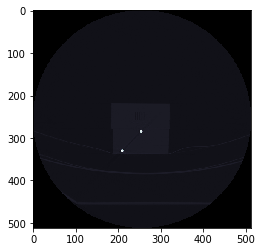

In [10]:
filename = file_names[141]
dataset = pydicom.dcmread(filename)

print("Filename.........:", filename)
print("Storage type.....:", dataset.SOPClassUID)

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

In [11]:
image_stack = np.empty([len(file_names), dataset.pixel_array.shape[0], dataset.pixel_array.shape[1]])
voxel_locations = np.empty(image_stack.shape)
datasets = []

for i, filename  in enumerate(file_names):
    dataset = pydicom.dcmread(filename)
    datasets.append(dataset)
    image_stack[i, :,:] = dataset.pixel_array

In [12]:
print("Slice location...:", datasets[150].get('SliceLocation', "(missing)"))
print("Slice location...:", datasets[151].get('SliceLocation', "(missing)"))

Slice location...: 31.7005
Slice location...: 32.3255


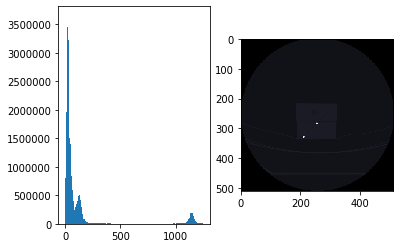

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

plt.subplot(1,2,1)
plt.hist(image_stack.ravel(),256,[0,1250])
plt.subplot(1,2,2)
plt.imshow(image_stack[141,:,:], cmap=plt.cm.bone)
plt.savefig('subplotted', bbox_inches='tight')

plt.show()

In [14]:
 (datasets[1].get('SliceLocation', "(missing)") - datasets[0].get('SliceLocation', "(missing)"))

0.625

## Segmentation based on brightness

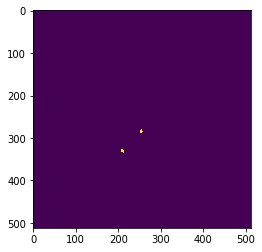

In [15]:
slices, rows, cols = np.where(image_stack > 2000)

img_example = np.zeros([512,512])
img_example[rows[np.where(slices==141)],cols[np.where(slices==141)]] = 1
plt.imshow(img_example)

slices = slices * (datasets[1].get('SliceLocation', "(missing)") - datasets[0].get('SliceLocation', "(missing)"))
rows = rows * dataset.PixelSpacing[0]
cols = cols * dataset.PixelSpacing[1]

## Point clustering

<IPython.core.display.Javascript object>


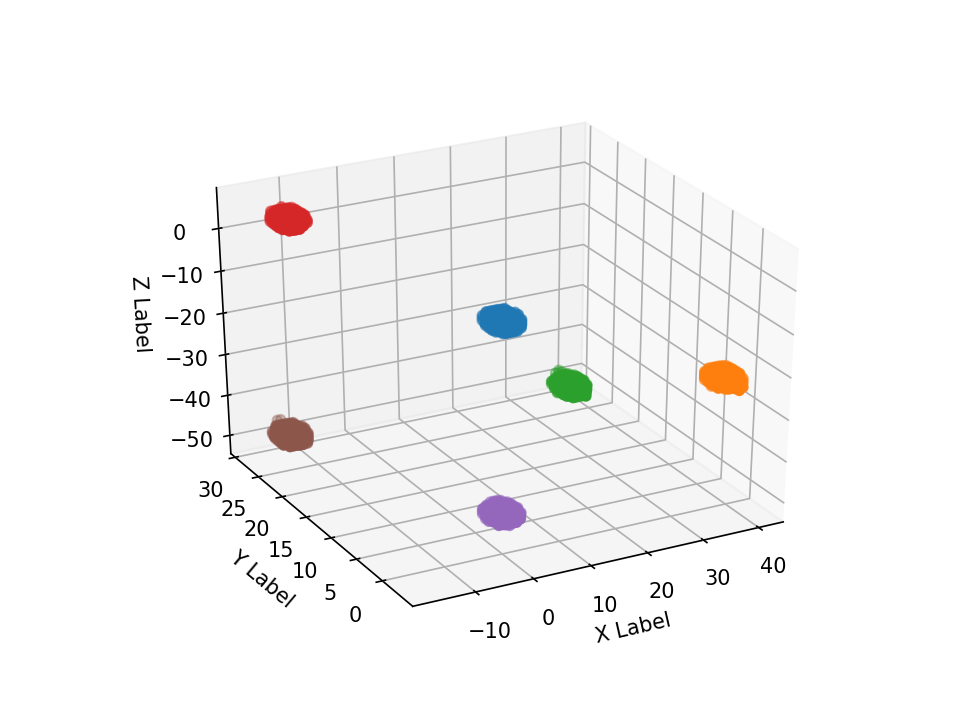

In [25]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

from scipy.cluster.vq import kmeans,vq

data = np.vstack([slices, rows, cols]).astype(float).T
#centroids = centroids[:,0:3] - centroids[None,0,0:3].repeat(6,axis=1) 

centroids,_ = kmeans(data,6)
idx,_ = vq(data,centroids)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

index = 0

for i in range(6):
    ax.scatter(data[idx==i,0] - centroids[index,0], data[idx==i,1] - centroids[index,1], (data[idx==i,2] - centroids[index,2]))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Plot centroids

<IPython.core.display.Javascript object>


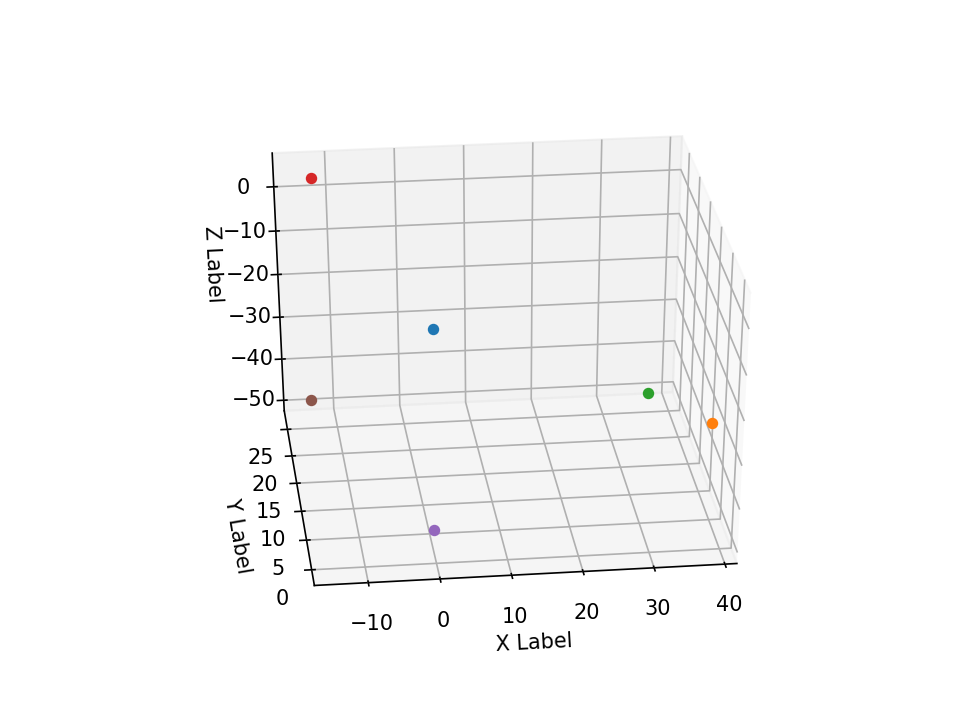

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

index = 0

for i in range(6):
    ax.scatter(centroids[i,0] - centroids[index,0], centroids[i,1] - centroids[index,1], (centroids[i,2] - centroids[index,2]))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Save centroids

In [27]:
np.save('centroids.npy', centroids)